## Definitions

In [3]:
from keras.models import Sequential, load_model
from keras.layers import Dense,Dropout
from keras.regularizers import l1,l2,l1_l2
from keras.optimizers import Adam
import keras.backend as K
import sys
import utils
import random
import numpy as np
import pandas as pd
import pickle

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve,auc
import matplotlib.pyplot as plt
from inspect import signature

from sklearn.metrics import average_precision_score

from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Performs classification using Logistic Regression.

FREQ_DIST_FILE = '../../data/df-no-comas-service-linear-freqdist.pkl'
BI_FREQ_DIST_FILE = '../../data/df-no-comas-service-linear-freqdist-bi.pkl'
DOC_FREQ_DIST_FILE = '../../data/df-no-comas-service-linear-freqdist-doc.pkl'
DOC_BI_FREQ_DIST_FILE = '../../data/df-no-comas-service-linear-freqdist-doc-bi.pkl'
TRAIN_PROCESSED_FILE = '../../data/df_hand-service-linear.csv'

FREQ_DIST_FILE_GLOVE = '../../data/df-no-comas-original-linear-freqdist.pkl'
BI_FREQ_DIST_FILE_GLOVE = '../../data/df-no-comas-original-linear-freqdist-bi.pkl'
TRAIN_PROCESSED_FILE_GLOVE = '../../data/df_hand-original-linear.csv'
GLOVE_FILE = '../../data/glove.6B.50d.txt'
DIM=50

TRAIN = True
UNIGRAM_SIZE = 10000
VOCAB_SIZE = UNIGRAM_SIZE
USE_BIGRAMS = True
if USE_BIGRAMS:
    BIGRAM_SIZE = 5000
    VOCAB_SIZE = UNIGRAM_SIZE + BIGRAM_SIZE
FEAT_TYPE = 'naive_count'#'tfidf'#


def get_feature_vector(tweet):
    uni_feature_vector = []
    bi_feature_vector = []
    words = tweet.split()
    for i in range(len(words) - 1):
        word = words[i]
        next_word = words[i + 1]
        if unigrams.get(word):
            uni_feature_vector.append(word)
        if USE_BIGRAMS:
            if bigrams.get((word, next_word)):
                bi_feature_vector.append((word, next_word))
    if len(words) >= 1:
        if unigrams.get(words[-1]):
            uni_feature_vector.append(words[-1])
    return uni_feature_vector, bi_feature_vector

def inverse_doc_freq(querry_res):
    if querry_res == None: return np.log(1e5)
    else: return np.log(1e5/(1+querry_res)) 

def extract_X_y(tweets,feat_type=FEAT_TYPE):
    #Only one iteration
    if(FEAT_TYPE == 'naive_count'):
        for X, y in extract_features(tweets,feat_type=feat_type, batch_size=len(tweets), test_file=False):
            return X, y
    elif(FEAT_TYPE == 'tfidf'):
        features = np.zeros((len(tweets), VOCAB_SIZE))
        labels = np.zeros(len(tweets))
        for j, tweet in enumerate(tweets):
            tweet_words = tweet[2][0]
            tweet_bigrams = tweet[2][1]
            labels[j] = tweet[1]
            for word in tweet_words:
                idx = unigrams.get(word)
                if idx:
                    features[j, idx] += inverse_doc_freq(doc_freq.get(word))/(1+len(tweet_words))#np.log(1+len(tweet_words))
                
            for bigram in tweet_bigrams:
                idx = bigrams.get(bigram)
                if idx:
                    features[j, UNIGRAM_SIZE + idx] += inverse_doc_freq(doc_freq.get(bigram))/(1+len(tweet_bigrams))#np.log(1+len(tweet_bigrams))
        return features, labels

def extract_features(tweets, batch_size=500, test_file=True, feat_type='presence'):
    num_batches = int(np.ceil(len(tweets) / float(batch_size)))
    for i in range(num_batches):
        batch = tweets[i * batch_size: (i + 1) * batch_size]
        features = np.zeros((batch_size, VOCAB_SIZE))
        labels = np.zeros(batch_size)
        for j, tweet in enumerate(batch):
            if test_file:
                tweet_words = tweet[1][0]
                tweet_bigrams = tweet[1][1]
            else:
                tweet_words = tweet[2][0]
                tweet_bigrams = tweet[2][1]
                labels[j] = tweet[1]
            if feat_type == 'presence':
                tweet_words = set(tweet_words)
                tweet_bigrams = set(tweet_bigrams)
            for word in tweet_words:
                idx = unigrams.get(word)
                if idx:
                    features[j, idx] += 1
            if USE_BIGRAMS:
                for bigram in tweet_bigrams:
                    idx = bigrams.get(bigram)
                    if idx:
                        features[j, UNIGRAM_SIZE + idx] += 1
        yield features, labels


def process_tweets(csv_file, test_file=True):
    tweets = []
    print ('Generating feature vectors')
    with open(csv_file, 'r') as csv:
        lines = csv.readlines()
        total = len(lines)
        for i, line in enumerate(lines):
            if test_file:
                tweet_id, dummy, tweet = line.split(',')
            else:
                tweet_id, sentiment, tweet = line.split(',')
            feature_vector = get_feature_vector(tweet)
            if test_file:
                tweets.append((tweet_id, feature_vector))
            else:
                tweets.append((tweet_id, int(sentiment), feature_vector))
            utils.write_status(i + 1, total)
    print ('\n')
    return tweets


def build_model(lr=0.001,dropout_rate=0.4,l1reg=0.001,l2reg=0.001):
    model = Sequential()
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, input_dim=VOCAB_SIZE, activation='sigmoid',kernel_regularizer=l1_l2(l1reg,l2reg)))
    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(lr=lr), metrics=['accuracy',mean_pred])
    return model

def build_model_2(lr = 0.001, n1= 100):
    model = Sequential()
    model.add(Dropout(0.3))
    model.add(Dense(n1, input_dim=VOCAB_SIZE, activation='relu',kernel_regularizer=l1_l2(1e-3,1e-2)))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid',kernel_regularizer=l1_l2(1e-2,1e-3)))
    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(lr=lr), metrics=['accuracy',mean_pred])
    return model

def build_model_3(lr = 0.001, n1= 100, n2 = 30):
    model = Sequential()
    model.add(Dropout(0.4))
    model.add(Dense(n1, input_dim=VOCAB_SIZE, activation='relu',kernel_regularizer=l1(1e-4)))
    model.add(Dropout(0.5))
    model.add(Dense(n2, input_dim=VOCAB_SIZE, activation='relu',kernel_regularizer=l1(1e-4)))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid',kernel_regularizer=l1(1e-5)))
    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(lr=lr), metrics=['accuracy',mean_pred])
    return model

#def evaluate_model(model, val_tweets):
#    correct, total = 0, len(val_tweets)
#    for val_set_X, val_set_y in extract_features(val_tweets, feat_type=FEAT_TYPE, test_file=False):
#        prediction = model.predict_on_batch(val_set_X)
#        prediction = np.round(prediction)
#        correct += np.sum(prediction == val_set_y[:, None])
#    return float(correct) / total

def evaluate_model(model, val_tweets):
    correct, total = 0, len(val_tweets)
    for val_set_X, val_set_y in extract_features(val_tweets,batch_size=total, feat_type=FEAT_TYPE, test_file=False):
        prediction = model.predict_on_batch(val_set_X)
        prediction = np.round(prediction)
        correct += np.sum(prediction == val_set_y[:, None])

        pred = prediction
        truth = val_set_y

    save_to_file = open('compare-bi.csv', 'a')
    save_to_file.write('pred,truth\n')
    for i in range(len(pred)):
        save_to_file.write('%d,%d\n' % (pred[i],truth[i]))
        
    return float(correct) / total


def mean_pred(y_true, y_pred):
    return K.mean(y_pred)



    """
    for j in range(nb_epochs):
        i = 1
        for training_set_X, training_set_y in extract_features(train_tweets, feat_type=FEAT_TYPE, batch_size=batch_size, test_file=False):
            o = model.train_on_batch(training_set_X, training_set_y)
            sys.stdout.write('\rIteration %d/%d, loss:%.4f, acc:%.4f, mean_pred:%.4f' %
                             (i, n_train_batches, o[0], o[1],o[2]))
            sys.stdout.flush()
            i += 1
        val_acc = evaluate_model(model, val_tweets)
        print ('\nEpoch: %d, val_acc:%.4f' % (j + 1, val_acc))
        random.shuffle(train_tweets)
        if val_acc > best_val_acc:
            print ('Accuracy improved from %.4f to %.4f, saving model' % (best_val_acc, val_acc))
            best_val_acc = val_acc
            model.save('best_model.h5')
    print ('Testing')
    del train_tweets
    del model

    model = load_model('best_logistic_model.h5')
    test_tweets = process_tweets(TEST_PROCESSED_FILE, test_file=True)
    n_test_batches = int(np.ceil(len(test_tweets) / float(batch_size)))
    predictions = np.array([])
    print ('Predicting batches')
    i = 1
    for test_set_X, _ in extract_features(test_tweets, feat_type=FEAT_TYPE, batch_size=batch_size, test_file=True):
        prediction = np.round(model.predict_on_batch(test_set_X).flatten())
        predictions = np.concatenate((predictions, prediction))
        utils.write_status(i, n_test_batches)
        i += 1
    predictions = [(str(j), int(predictions[j]))
                   for j in range(len(test_tweets))]
    utils.save_results_to_csv(predictions, 'logistic.csv')
    print ('\nSaved to logistic.csv')
    """
def shuffle_split_data(tweets, validation_split=0.1,random_seed = 42):
    """Split the data into training and validation sets

    Args:
        tweets (list): list of tuples
        validation_split (float, optional): validation split %

    Returns:
        (list, list): training-set, validation-set
    """
    index = int((1 - validation_split) * len(tweets))
    random.Random(random_seed).shuffle(tweets)
    return tweets[:index], tweets[index:]

#def extract_X_y(tweets,feat_type=FEAT_TYPE):
#    #Only one iteration
#    for X, y in extract_features(tweets,feat_type=feat_type, batch_size=len(tweets), test_file=False):
#        return X, y
    
def stratifiedSplit(X,y,test_size=0.1,random_state=42):
    sss = StratifiedShuffleSplit(test_size=test_size,random_state=random_state,n_splits = 1)
    sss.get_n_splits(X,y)
    
    for train_id, test_id in sss.split(X, y):
        X_train_val,y_train_val = X[train_id], y[train_id]
        X_test,y_test = X[test_id], y[test_id]
    
    return X_train_val, y_train_val, X_test, y_test

def stratifiedSplit_2Xs(X,X2,y,test_size=0.1,random_state=42):
    sss = StratifiedShuffleSplit(test_size=test_size,random_state=random_state,n_splits = 1)
    sss.get_n_splits(X,y)
    
    for train_id, test_id in sss.split(X, y):
        X_train_val,y_train_val,X2_train_val = X[train_id], y[train_id], X2[train_id]
        X_test,y_test,X2_test = X[test_id], y[test_id],X2[test_id] 
    
    return X_train_val, y_train_val, X_test, y_test, X2_train_val, X2_test

def precision_recall(y_test,y_score,color='b',y_lower=0.0):
    average_precision = average_precision_score(y_test, y_score)
    precision, recall, _ = precision_recall_curve(y_test, y_score)
    
    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
    plt.step(recall, precision, color=color, alpha=0.6,
         where='post')
    #plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([y_lower, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
    
def accuracy(y_test,y_score): return np.mean(y_test == (y_score>0.5))

def evaluate_model_pred(y_test,y_score,model_name,metric='precision-recall',color='b'):
    if metric == 'precision-recall':
        print(model_name+" has AP:", average_precision_score(y_test, y_score), 
              "accuracy", accuracy(y_test,y_score))
        precision_recall(y_test,y_score)
    elif metric == 'roc':
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        lw = 2
        plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic example')
        plt.legend(loc="lower right")
        
    
def show_significant_words(coeff,method='naive', length = 100):
    df_uni = pd.DataFrame.from_dict(unigrams,orient='index')
    df_bi = pd.DataFrame.from_dict(bigrams,orient='index')
    df_dict = pd.concat([df_uni, df_bi])
    big_pos_coeff = coeff.argsort()[-length:][::-1]
    big_neg_coeff = coeff.argsort()[:length]
    pos_res = []
    print(coeff[big_pos_coeff][0],coeff[big_pos_coeff][-1])
    print(coeff[big_neg_coeff][0],coeff[big_neg_coeff][-1])
    print('positive words are:')
    print([df_dict.iloc[idx].name for idx in big_pos_coeff if idx<VOCAB_SIZE] )
    print('negative words are:')
    print([df_dict.iloc[idx].name for idx in big_neg_coeff if idx<VOCAB_SIZE])

Using TensorFlow backend.


## Glove embedding methods

In [4]:
def get_glove_vectors(vocab):
    print('Looking for GLOVE vectors')
    glove_vectors = {}
    found = 0
    with open(GLOVE_FILE, 'r') as glove_file:
        for i, line in enumerate(glove_file):
            #utils.write_status(i + 1, 0)
            tokens = line.split()
            word = tokens[0]
            if vocab.get(word):
                vector = [float(e) for e in tokens[1:]]
                glove_vectors[word] = np.array(vector)
                found += 1
    print('\n')
    print('Found %d words in GLOVE' % found)
    return glove_vectors


def get_feature_vector_w2i(tweet):
    words = tweet.split()
    feature_vector = []
    for i in range(len(words) - 1):
        word = words[i]
        if vocab.get(word) is not None:
            feature_vector.append(vocab.get(word))
        else: 
            feature_vector.append(vocab.get('404MISSINGWORD404')) 
    if len(words) >= 1:
        if vocab.get(words[-1]) is not None:
            feature_vector.append(vocab.get(words[-1]))
    return feature_vector

def get_feature_vector_w2v(tweet):
    words = tweet.split()
    feature_vector = []
    for i in range(len(words)):
        word = words[i]
        if type(glove_vectors.get(word))!=type(None):
            feature_vector.append(glove_vectors.get(word))
        else: 
            feature_vector.append(glove_vectors.get('404MISSINGWORD404')) 
    #if len(words) >= 1:
    #    if vocab.get(words[-1]) is not None:
    #        feature_vector.append(vocab.get(words[-1]))
    return feature_vector


def process_tweets_w2i(csv_file, test_file=True):
    tweets = []
    labels = []
    print('Generating feature vectors')
    with open(csv_file, 'r') as csv:
        lines = csv.readlines()
        total = len(lines)
        for i, line in enumerate(lines):
            if test_file:
                tweet_id, dummy, tweet = line.split(',')
            else:
                tweet_id, sentiment, tweet = line.split(',')
            feature_vector = get_feature_vector_w2v(tweet)
            if test_file:
                tweets.append(feature_vector)
            else:
                tweets.append(feature_vector)
                labels.append(int(sentiment))
            #utils.write_status(i + 1, total)
    print('\n')
    return tweets, np.array(labels)

def process_tweets_w2v(csv_file, test_file=True):
    tweets = []
    labels = []
    print('Generating feature vectors')
    with open(csv_file, 'r') as csv:
        lines = csv.readlines()
        total = len(lines)
        for i, line in enumerate(lines):
            if test_file:
                tweet_id, dummy, tweet = line.split(',')
            else:
                tweet_id, sentiment, tweet = line.split(',')
            feature_vector = get_feature_vector_w2v(tweet)
            if test_file:
                tweets.append(feature_vector)
            else:
                tweets.append(feature_vector)
                labels.append(int(sentiment))
            #utils.write_status(i + 1, total)
    print('\n')
    return tweets, np.array(labels) 

def pad_vec_tweets(tweets, max_length):
    result = []
    for tweet in tweets:
        tweet = np.array(tweet)
        #print(tweet.shape)
        if len(tweet) == 0:
            result.append(np.zeros((max_length,DIM)))
        elif len(tweet)<max_length:
            padding = np.zeros((max_length-len(tweet),DIM))
            padded_tweet = np.concatenate([tweet,padding])
            result.append(padded_tweet)
        else:
            result.append(tweet[:max_length])
    return np.array(result)

## Random Seed

In [5]:
#np.random.seed(1337)
#random_seed = 33 #(2 layers the best)
#random_seed = 133 #(2 layers the best, all models bad)
#random_seed = 51 #nltk bad
random_seed = 540
np.random.seed(random_seed)

## Prepare Data (Glove Embedding)

In [7]:
train = True
np.random.seed(1337)
#np.random.seed(42)
vocab_size = 54488 + 1
batch_size = 500
max_length = 100
filters = 600
kernel_size = 3

vocab = utils.top_n_words(FREQ_DIST_FILE_GLOVE, vocab_size-1, shift=1)
glove_vectors = get_glove_vectors(vocab)
#Handle unkown words

vocab['404MISSINGWORD404'] = vocab_size
glove_vectors['404MISSINGWORD404']=np.mean([v for _,v in glove_vectors.items()],axis = 0)

Looking for GLOVE vectors


Found 36502 words in GLOVE


In [8]:
def word2vec(word, glove_vectors=glove_vectors):
    if type(glove_vectors.get(word.lower()))!=type(None): 
        return glove_vectors[word.lower()]
    else: 
        return glove_vectors['404MISSINGWORD404']
    
def sentence2vec(sentence, glove_vectors=glove_vectors):
    return np.sum([word2vec(word,glove_vectors=glove_vectors) for word in sentence.split()],axis=0)

In [115]:
#use bag of words together with embedding
unigrams_org = utils.top_n_words(FREQ_DIST_FILE_GLOVE, UNIGRAM_SIZE)
bigrams_org = utils.top_n_bigrams(BI_FREQ_DIST_FILE_GLOVE, BIGRAM_SIZE)

unigrams = unigrams_org
bigrams = bigrams_org

tweets = process_tweets(TRAIN_PROCESSED_FILE_GLOVE, test_file=False)
X,y = extract_X_y(tweets,feat_type=FEAT_TYPE)

#del unigrams
#del bigrams

Generating feature vectors
Processing 693/693



In [82]:
#Embeded version of the bag of words
glove_matrix_uni = np.array([word2vec(key) for key in unigrams_org])
glove_matrix_uni.shape

glove_matrix_bi = np.array([np.concatenate([word2vec(key[0]),word2vec(key[1])]) for key in bigrams_org])
glove_matrix_bi.shape

X_emb = np.concatenate([X[:,:UNIGRAM_SIZE]@glove_matrix_uni, X[:,UNIGRAM_SIZE:]@glove_matrix_bi],axis = 1)

X_emb.shape

(693, 150)

## Training models with Glove

In [124]:
X=X_emb

X_train_val,y_train_val,X_test, y_test = stratifiedSplit(X,y,test_size = 0.1, random_state = random_seed)
X_train,y_train,X_val, y_val = stratifiedSplit(X_train_val,y_train_val,test_size = 0.1, random_state = random_seed+1)

print(len(y_train),len(y_val),len(y_test))
print(np.mean(y_train == 1),np.mean(y_val == 1),np.mean(y_test == 1))

#del X,X_emb,y

560 63 70
0.5517857142857143 0.5555555555555556 0.5571428571428572


0.5396825396825397
logistic has AP: 0.5899008780187084 accuracy 0.5857142857142857


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


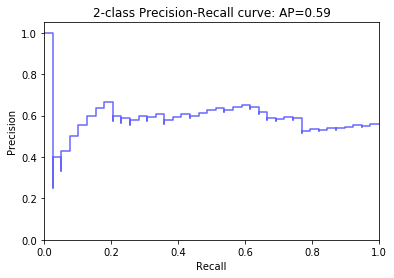

In [125]:
logistic = LogisticRegression(random_state=0, solver='lbfgs')#regularization,log range, optimizer tolerance sklearn grid search.


logistic.fit(X_train, y_train)

pred_val_logistic = logistic.predict_proba(X_val)[:,1]

print(np.mean((pred_val_logistic>0.5) == y_val))

y_score_logistic = logistic.predict_proba(X_test)[:,1]
evaluate_model_pred(y_test,y_score_logistic,model_name='logistic')

In [126]:
model = build_model(lr=0.001,dropout_rate=0.1,l1reg=0.001,l2reg=0.001)

In [128]:
model.fit(X_train, y_train, batch_size=15, epochs=10, validation_data = (X_val,y_val), shuffle=True)

Train on 560 samples, validate on 63 samples
Epoch 1/10
560/560 [==============================] - 0s 186us/step - loss: 0.8463 - acc: 0.6107 - mean_pred: 0.5593 - val_loss: 1.0341 - val_acc: 0.4286 - val_mean_pred: 0.6797
Epoch 2/10
560/560 [==============================] - 0s 179us/step - loss: 0.7703 - acc: 0.6250 - mean_pred: 0.5307 - val_loss: 0.8623 - val_acc: 0.6032 - val_mean_pred: 0.5300
Epoch 3/10
560/560 [==============================] - 0s 172us/step - loss: 0.7738 - acc: 0.6214 - mean_pred: 0.5502 - val_loss: 0.8905 - val_acc: 0.4603 - val_mean_pred: 0.5931
Epoch 4/10
560/560 [==============================] - 0s 170us/step - loss: 0.7478 - acc: 0.6304 - mean_pred: 0.5563 - val_loss: 0.8678 - val_acc: 0.5079 - val_mean_pred: 0.5611
Epoch 5/10
560/560 [==============================] - 0s 172us/step - loss: 0.7561 - acc: 0.6411 - mean_pred: 0.5482 - val_loss: 0.8976 - val_acc: 0.5238 - val_mean_pred: 0.6028
Epoch 6/10
560/560 [==============================] - 0s 175us/st

1 layer has AP: 0.6382553759758716 accuracy 0.5163265306122449


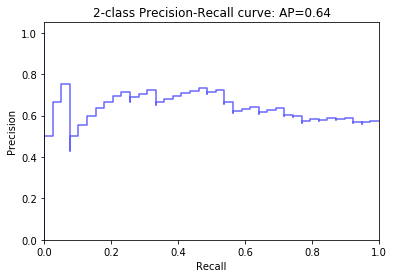

In [129]:
y_model = model.predict(X_test)
evaluate_model_pred(y_test,y_model,model_name='1 layer')

In [130]:
def build_model_2(lr = 0.001, n1= 100):
    model = Sequential()
    model.add(Dropout(0.2))
    model.add(Dense(n1, #input_dim=VOCAB_SIZE, 
                    activation='relu',kernel_regularizer=l1(1e-3)))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid',kernel_regularizer=l1(1e-3)))
    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(lr=lr), metrics=['accuracy',mean_pred])
    return model

model_2 = build_model_2(lr = 1e-3, n1 = 100)

In [135]:
model_2.fit(X_train, y_train, batch_size=10, epochs=10, validation_data = (X_val,y_val), shuffle=True)

Train on 560 samples, validate on 63 samples
Epoch 1/10
560/560 [==============================] - 0s 414us/step - loss: 1.4047 - acc: 0.6536 - mean_pred: 0.5410 - val_loss: 1.4042 - val_acc: 0.5556 - val_mean_pred: 0.5345
Epoch 2/10
560/560 [==============================] - 0s 379us/step - loss: 1.3300 - acc: 0.6518 - mean_pred: 0.5428 - val_loss: 1.3981 - val_acc: 0.5397 - val_mean_pred: 0.5473
Epoch 3/10
560/560 [==============================] - 0s 376us/step - loss: 1.3515 - acc: 0.6768 - mean_pred: 0.5252 - val_loss: 1.3520 - val_acc: 0.6032 - val_mean_pred: 0.6095
Epoch 4/10
560/560 [==============================] - 0s 380us/step - loss: 1.3292 - acc: 0.6339 - mean_pred: 0.5301 - val_loss: 1.3373 - val_acc: 0.5873 - val_mean_pred: 0.5707
Epoch 5/10
560/560 [==============================] - 0s 379us/step - loss: 1.2929 - acc: 0.6804 - mean_pred: 0.5626 - val_loss: 1.3049 - val_acc: 0.5556 - val_mean_pred: 0.5239
Epoch 6/10
560/560 [==============================] - 0s 389us/st

2-layer has AP: 0.6457074342608231 accuracy 0.503265306122449


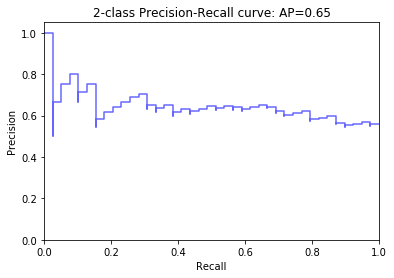

In [136]:
y_model_2 = model_2.predict_proba(X_test)
evaluate_model_pred(y_test,y_model_2,model_name='2-layer')

In [137]:
def build_model_3(lr = 0.001, n1= 100, n2 = 30):
    model = Sequential()
    model.add(Dropout(0.1))
    model.add(Dense(n1, input_dim=VOCAB_SIZE, activation='relu',kernel_regularizer=l1(1e-4)))
    model.add(Dropout(0.1))
    model.add(Dense(n2, input_dim=VOCAB_SIZE, activation='relu',kernel_regularizer=l1(1e-3)))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='sigmoid',kernel_regularizer=l1(1e-4)))
    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(lr=lr), metrics=['accuracy',mean_pred])
    return model

model_3 = build_model_3(lr = 5e-3, n1 = 100, n2 = 30)

In [140]:
model_3.fit(X_train, y_train, batch_size=10, epochs=10, validation_data = (X_val,y_val), shuffle=True)

Train on 560 samples, validate on 63 samples
Epoch 1/10
560/560 [==============================] - 0s 453us/step - loss: 0.7376 - acc: 0.6268 - mean_pred: 0.5509 - val_loss: 0.8056 - val_acc: 0.5238 - val_mean_pred: 0.5838
Epoch 2/10
560/560 [==============================] - 0s 451us/step - loss: 0.7130 - acc: 0.6643 - mean_pred: 0.5473 - val_loss: 0.8800 - val_acc: 0.5079 - val_mean_pred: 0.6672
Epoch 3/10
560/560 [==============================] - 0s 453us/step - loss: 0.6976 - acc: 0.6768 - mean_pred: 0.5439 - val_loss: 0.8243 - val_acc: 0.5079 - val_mean_pred: 0.5653
Epoch 4/10
560/560 [==============================] - 0s 465us/step - loss: 0.7564 - acc: 0.6375 - mean_pred: 0.5555 - val_loss: 0.8249 - val_acc: 0.5556 - val_mean_pred: 0.6418
Epoch 5/10
560/560 [==============================] - 0s 448us/step - loss: 0.7352 - acc: 0.6232 - mean_pred: 0.5875 - val_loss: 0.8078 - val_acc: 0.5238 - val_mean_pred: 0.5903
Epoch 6/10
560/560 [==============================] - 0s 461us/st

2-layer has AP: 0.6386071064558064 accuracy 0.5261224489795918


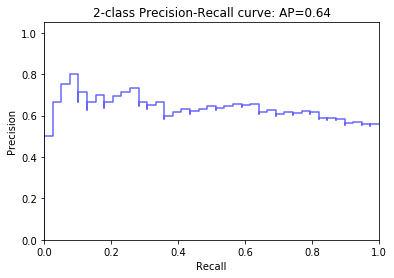

In [141]:
y_model_3 = model_3.predict_proba(X_test)
evaluate_model_pred(y_test,y_model_3,model_name='2-layer')

## Prepare Data (Trad embedding)

In [563]:
#with open(DOC_FREQ_DIST_FILE, 'rb') as pkl_file:
#        doc_freq = pickle.load(pkl_file)
#with open(DOC_BI_FREQ_DIST_FILE, 'rb') as pkl_file:
#        doc_freq_bi = pickle.load(pkl_file)

In [9]:
df_hand_p = pd.read_csv(TRAIN_PROCESSED_FILE,header=None)
df_hand_p.columns=['id','sentiment','text']
df_hand_p.set_index('id')

df_titles = pd.read_csv("../df-no-comas-title-linear.csv",header=None)
df_titles.columns=['id','sentiment','title']
df_titles.set_index('id')

title_dict = dict(np.array([df_titles.id.values,df_titles.title.values]).T)

titles = [title_dict[idd] for idd in df_hand_p.id.values]

titles_vec = np.array([sentence2vec(title) for title in titles])

In [10]:
unigrams = utils.top_n_words(FREQ_DIST_FILE, UNIGRAM_SIZE)
if USE_BIGRAMS: bigrams = utils.top_n_bigrams(BI_FREQ_DIST_FILE, BIGRAM_SIZE)
    
tweets = process_tweets(TRAIN_PROCESSED_FILE, test_file=False)

Generating feature vectors
Processing 693/693



In [11]:
X,y = extract_X_y(tweets,feat_type=FEAT_TYPE)

X = np.concatenate([X,titles_vec],axis=1)

#X_train_val,y_train_val,X_test, y_test = stratifiedSplit(X,y,test_size = 0.1, random_state = random_seed)
#X_train,y_train,X_val, y_val = stratifiedSplit(X_train_val,y_train_val,test_size = 0.1, random_state = random_seed+1)
df_hand_o = pd.read_csv("../df_hand-original-linear.csv",names=['id','sent','text'])
X_org = df_hand_o.text.values

X_train_val,y_train_val,X_test, y_test, X_org_train_val, X_org_test = \
    stratifiedSplit_2Xs(X,X_org,y,test_size = 0.1, random_state = random_seed)
X_train,y_train,X_val, y_val, X_org_train, X_org_val = \
    stratifiedSplit_2Xs(X_train_val,X_org_train_val,y_train_val,test_size = 0.1, random_state = random_seed+1)
print(len(y_train),len(y_val),len(y_test))
print(np.mean(y_train == 1),np.mean(y_val == 1),np.mean(y_test == 1))

560 63 70
0.5517857142857143 0.5555555555555556 0.5571428571428572


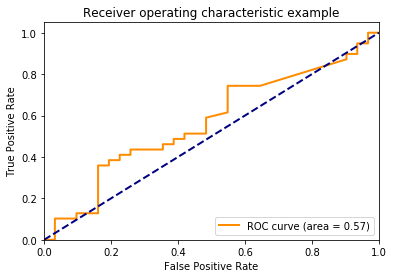

In [12]:
nltk_sentiment=SentimentIntensityAnalyzer()

y_nltk = np.array([nltk_sentiment.polarity_scores(comment)['compound'] for comment in X_org_test])

y_nltk = (y_nltk+1)/2

evaluate_model_pred(y_test,y_nltk,model_name='nltk',metric='roc')

## Advanced train-test split

In [546]:
sss = StratifiedShuffleSplit(test_size=0.1,random_state=random_seed,n_splits = 10)
sss.get_n_splits(X,y)
    
for train_id, test_id in sss.split(X, y):
    print(len(test_id))

70
70
70
70
70
70
70
70
70
70


In [503]:
r_seeds = []

Xs_train_val = []
Xs_val = []
Xs_train = []
Xs_test = []

Xs_org_train_val = []
Xs_org_val = []
Xs_org_train = []
Xs_org_test = []

ys_train_val = []
ys_train = []
ys_val = []
ys_test = []

for i in range(5):
    r_seed = random_seed + i*7+i**2
    r_seeds.append(r_seed)
    print(r_seed)
    X_train_val,y_train_val,X_test, y_test, X_org_train_val, X_org_test = \
        stratifiedSplit_2Xs(X,X_org,y,test_size = 0.1, random_state = r_seed)
    X_train,y_train,X_val, y_val, X_org_train, X_org_val = \
        stratifiedSplit_2Xs(X_train_val,X_org_train_val,y_train_val,test_size = 0.1, random_state = r_seed)
    Xs_train_val.append(X_train_val)
    Xs_train.append(X_train)
    Xs_val.append(X_val)
    Xs_test.append(X_test)
    Xs_org_test.append(X_org_test)
    ys_train_val.append(y_train_val)
    ys_train.append(y_train)
    ys_val.append(y_val)
    ys_test.append(y_test)

51
59
69
81
95


In [504]:
precisions_nltk = []
recalls_nltk = []
for i,y_t in enumerate(ys_test):
    y_nltk = np.array([nltk_sentiment.polarity_scores(comment)['compound'] for comment in Xs_org_test[i]])
    y_nltk = (y_nltk+1)/2
    precision, recall, _ = precision_recall_curve(ys_test[i], y_nltk)
    precisions_nltk.append(precision)
    print(len(precision))
    recalls_nltk.append(recall)
    
#ave_pr_nltk = np.mean(precisions_nltk,axis=0)
#ave_rec_nltk = np.mean(recalls_nltk,axis=0)

49
54
48
48
46


In [499]:
np.array(precisions_nltk).shape

(5,)

## Direct trainings

0.6190476190476191


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


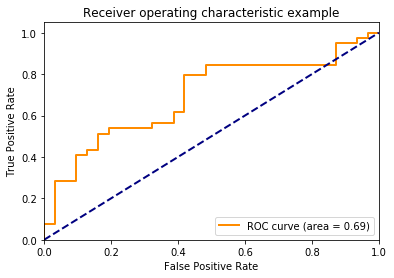

In [13]:
logistic = LogisticRegression(random_state=0, solver='lbfgs')#regularization,log range, optimizer tolerance sklearn grid search.


logistic.fit(X_train, y_train)

pred_val_logistic = logistic.predict_proba(X_val)[:,1]

print(np.mean((pred_val_logistic>0.5) == y_val))

y_score_logistic = logistic.predict_proba(X_test)[:,1]
evaluate_model_pred(y_test,y_score_logistic,model_name='logistic',metric='roc')

In [21]:
logistic.coef_[0][unigrams['negat']]

0.0

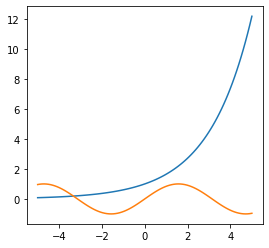

In [584]:
x = np.linspace(-5, 5, 100)
y1 = np.exp(0.5*x)
y2 = np.sin(x)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, y1)
ax.plot(x, y2)

ax.set_aspect(aspect=0.7)
plt.show()

In [594]:
fprb

array([0.        , 0.03225806, 0.03225806, 0.09677419, 0.09677419,
       0.16129032, 0.16129032, 0.16129032, 0.16129032, 0.19354839,
       0.19354839, 0.22580645, 0.22580645, 0.25806452, 0.25806452,
       0.32258065, 0.35483871, 0.35483871, 0.38709677, 0.38709677,
       0.41935484, 0.41935484, 0.48387097, 0.48387097, 0.48387097,
       0.5483871 , 0.5483871 , 0.58064516, 0.64516129, 0.90322581,
       0.90322581, 0.93548387, 0.93548387, 0.96774194, 0.96774194,
       1.        ])

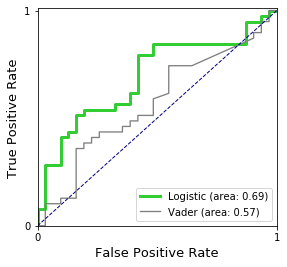

In [617]:
fpr, tpr, _ = roc_curve(y_test, y_score_logistic)
fprb, tprb, _ = roc_curve(y_test, y_nltk)
roc_auc = auc(fpr, tpr)
roc_aucb = auc(fprb, tprb)
lw = 2

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(fpr, tpr, color='limegreen',lw=lw*1.5, label='Logistic (area: %0.2f)' % roc_auc)
ax.plot(fprb, tprb, color='grey',lw=lw/1.5, label='Vader (area: %0.2f)' % roc_aucb)
ax.plot([0, 1], [0, 1], color='navy', lw=lw/2, linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.01])
ax.xaxis.set_ticks([0,1])
ax.yaxis.set_ticks([0,1])
ax.set_xlabel('False Positive Rate',fontsize=13)
ax.set_ylabel('True Positive Rate',fontsize=13)
ax.legend(loc="lower right")
ax.set_aspect(aspect=0.9)
plt.show()

In [226]:
X_train_mean_excluding_0 = np.nan_to_num(np.nanmean(np.where(np.isclose(X_train,0), np.nan, X_train),axis=0))
X_train_std = np.std(X_train,axis=0)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


In [618]:
df_uni = pd.DataFrame.from_dict(unigrams,orient='index')
df_bi = pd.DataFrame.from_dict(bigrams,orient='index')
df_dict = pd.concat([df_uni, df_bi])

df_dict.iloc[idx].name

NameError: name 'df_dict' is not defined

In [619]:
show_significant_words(logistic.coef_[0]*X_train_mean_excluding_0)
show_significant_words(logistic.coef_[0]*X_train_std)

1.8013367998966587 0.43790323858903835
-1.3137099905085623 -0.40148788679129105
positive words are:
['binoview', 'yen', 'great', 'thank', 'bolt', 'nice', 'pupil', 'l', 'power', 'order', 'n', 'report', 'thread', 'eye', 'ke', ('exit', 'pupil'), 'exit', 'pan', 'parallax', 'comment', ('num', 'xw'), 'new', 'ye', 'nagler', 'light', 'limit', 'storag', 'diagon', 'pair', 'let', 'also', 'travel', 'field', 'see', 'impress', 'ad', 'tripod', 'one', 'white', 'quot', 'cours', 'buy', 'scott', 'mct', 'frame', 'bino', 'polar', 'recoveri', 'view', 'dark', 'flock', 'need', 'tv', 'wednesday', 'special', 'offer', 'delo', 'boot', 'contrast', 'appar', 'bad', 'anoth', 'insul', 'could', 'fine', ('mewlon', 'num'), 'got', 'wait', 'unit', 'choic', 'today', 'use', 'orion', 'liner', 'quick', 'go', 'edg', 'sale', ('right', 'eye'), 'ebay', 'weight', 'speak', 'easi', ('focu', 'without'), ('come', 'focu'), 'tempt', 'awesom', 'ship', 'abl', 'pretti', 'market', 'updat', 'stockhold', ('pair', 'num'), 'mewlon', 'vanilla', '

In [1185]:
pkl_filename = "pickle_logistic_sentiment.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(logistic, file)

logistic has AP: 0.6877634104389934 accuracy 0.5714285714285714


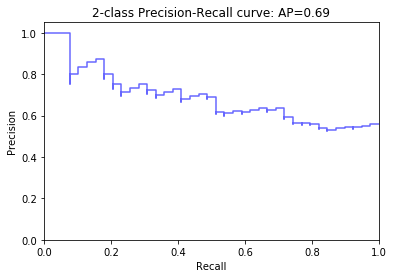

In [1187]:
# Load from file
with open(pkl_filename, 'rb') as file:
    pickle_model = pickle.load(file)
    
y_score_logistic = pickle_model.predict_proba(X_test)[:,1]
evaluate_model_pred(y_test,y_score_logistic,model_name='logistic',metric = 'roc')

In [431]:
model = build_model(lr = 0.001,l1reg=1e-3,l2reg=5e-2,dropout_rate=0.4)

#callbacks = [EarlyStopping(monitor='val_loss', patience=4),
#                 ModelCheckpoint(filepath='best_model_1.h5', monitor='val_loss', save_best_only=True)]

model.fit(X_train, y_train, batch_size=15, epochs=5, validation_data = (X_val,y_val), shuffle=True)
          #,callbacks=callbacks)

#model = load_model('best_model_1.h5',custom_objects={'mean_pred': mean_pred})
#y_train_pred = model.predict(X_train)
#y_val_pred = model.predict(X_val)
y_model = model.predict(X_test)

Train on 560 samples, validate on 63 samples
Epoch 1/5
560/560 [==============================] - 4s 7ms/step - loss: 0.7610 - acc: 0.5321 - mean_pred: 0.5324 - val_loss: 0.6837 - val_acc: 0.5714 - val_mean_pred: 0.5538
Epoch 2/5
560/560 [==============================] - 0s 799us/step - loss: 0.6758 - acc: 0.6286 - mean_pred: 0.5524 - val_loss: 0.6892 - val_acc: 0.6032 - val_mean_pred: 0.5459
Epoch 3/5
560/560 [==============================] - 0s 808us/step - loss: 0.6555 - acc: 0.6875 - mean_pred: 0.5581 - val_loss: 0.6870 - val_acc: 0.6349 - val_mean_pred: 0.5473
Epoch 4/5
560/560 [==============================] - 0s 791us/step - loss: 0.6552 - acc: 0.7125 - mean_pred: 0.5553 - val_loss: 0.6937 - val_acc: 0.6508 - val_mean_pred: 0.5383
Epoch 5/5
560/560 [==============================] - 0s 855us/step - loss: 0.6549 - acc: 0.7125 - mean_pred: 0.5446 - val_loss: 0.6938 - val_acc: 0.6667 - val_mean_pred: 0.5376


1 layer has AP: 0.7199834480585993 accuracy 0.5277551020408163


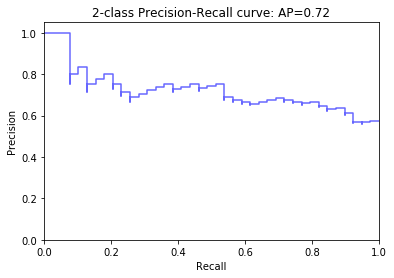

In [432]:
y_model = model.predict(X_test)
evaluate_model_pred(y_test,y_model,model_name='1 layer')

#show_significant_words(model.layers[1].get_weights()[0].reshape(-1)*X_train_mean_excluding_0)

#show_significant_words(model.layers[1].get_weights()[0].reshape(-1)*X_train_std)

In [ ]:
model_2 = build_model_2(lr = 1e-3, n1 = 100)

In [396]:
model_2.fit(X_train, y_train, batch_size=15, epochs=3, validation_data = (X_val,y_val), shuffle=True)

Train on 560 samples, validate on 63 samples
Epoch 1/3
560/560 [==============================] - 6s 11ms/step - loss: 5.1903 - acc: 0.5411 - mean_pred: 0.5507 - val_loss: 1.7536 - val_acc: 0.5079 - val_mean_pred: 0.5171
Epoch 2/3
560/560 [==============================] - 2s 4ms/step - loss: 1.3099 - acc: 0.6500 - mean_pred: 0.5468 - val_loss: 1.2199 - val_acc: 0.5714 - val_mean_pred: 0.5951
Epoch 3/3
560/560 [==============================] - 2s 4ms/step - loss: 1.1345 - acc: 0.6589 - mean_pred: 0.5587 - val_loss: 1.2078 - val_acc: 0.5556 - val_mean_pred: 0.5503


2-layer has AP: 0.6702035323558008 accuracy 0.5310204081632653


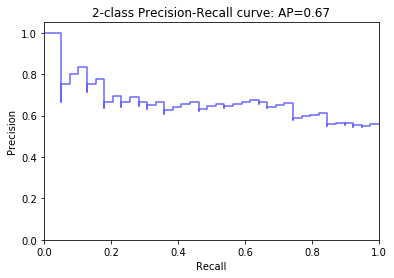

In [397]:
y_model_2 = model_2.predict_proba(X_test)
evaluate_model_pred(y_test,y_model_2,model_name='2-layer')

In [253]:
y_model_2_use = y_model_2

In [461]:
model_3 = build_model_3(lr = 1e-3, n1 = 50, n2 = 20)

In [476]:
model_3.fit(X_train, y_train, batch_size=15, epochs=1, validation_data = (X_val,y_val), shuffle=True)

Train on 560 samples, validate on 63 samples
Epoch 1/1
560/560 [==============================] - 1s 2ms/step - loss: 0.7014 - acc: 0.7286 - mean_pred: 0.5692 - val_loss: 0.7783 - val_acc: 0.6984 - val_mean_pred: 0.5490


3-layer has AP: 0.7332090962543335 accuracy 0.5179591836734694


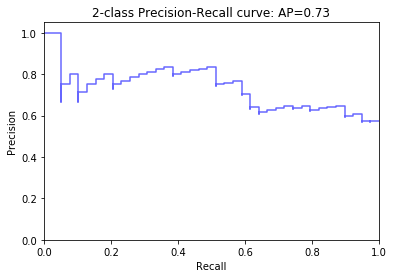

In [477]:
y_model_3 = model_3.predict_proba(X_test)
evaluate_model_pred(y_test,y_model_3,model_name='3-layer')

In [475]:
y_model_3_use = y_model_3

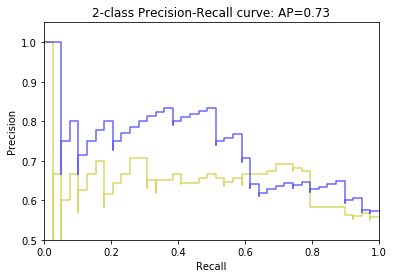

In [483]:
precision_recall(y_test,y_nltk, color = 'y',y_lower = 0.5)
#precision_recall(y_test,y_model)
#precision_recall(y_test,y_model_2,color='r')
precision_recall(y_test,y_model_3,color='b',y_lower = 0.5)
plt.show()

## Cross validation of logistic regression with keras

In [1246]:
def build_model(lr=0.001,dropout_rate=0.4,l1reg=0.001,l2reg=0.001):
    model = Sequential()
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, input_dim=VOCAB_SIZE, activation='sigmoid',kernel_regularizer=l1_l2(l1reg,l2reg)))
    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(lr=lr), metrics=['accuracy',mean_pred])
    return model

In [1243]:
def run_model_and_validate(X_train,y_train,X_val,y_val,lr=0.001,dropout_rate=0.4,l1reg=0.001,l2reg=0.001):
    model = build_model(lr=lr,dropout_rate=dropout_rate,l1reg=l1reg,l2reg=l2reg)
    callbacks = [EarlyStopping(monitor='val_loss', patience=2),
                 ModelCheckpoint(filepath='best_logistic_model.h5', monitor='val_loss', save_best_only=True)]
    model.fit(X_train, y_train, batch_size=30, epochs=30, validation_data = (X_val,y_val),
              shuffle=True, callbacks=callbacks,verbose=0)
    model = load_model('best_logistic_model.h5',custom_objects={'mean_pred': mean_pred})
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    return average_precision_score(y_train, y_train_pred),average_precision_score(y_val, y_val_pred)

In [1244]:
cross_val_datasets = []
for i in range(5):
    random_seed = i**2+31 + 51*i
    print("data set",i," with random seed:", random_seed)
    X_train,y_train,X_val, y_val = stratifiedSplit(X_train_val,y_train_val,
                                                   test_size = 0.1,random_state = random_seed)
    cross_val_datasets.append([X_train,y_train,X_val, y_val,random_seed])

data set 0  with random seed: 31
data set 1  with random seed: 83
data set 2  with random seed: 137
data set 3  with random seed: 193
data set 4  with random seed: 251


In [1247]:
#cross_val_res = []

In [1249]:
l2reg = [10,1,1e-1,1e-2,1e-3]
lrs = [1e-3]*len(l2reg)
dropout_rates = [0.4]*len(l2reg)
l1reg = [1e-2]*len(l2reg)


hyperparameters = np.array([lrs,dropout_rates,l1reg,l2reg]).T

hyperparameters

array([[1.e-03, 4.e-01, 1.e-02, 1.e+01],
       [1.e-03, 4.e-01, 1.e-02, 1.e+00],
       [1.e-03, 4.e-01, 1.e-02, 1.e-01],
       [1.e-03, 4.e-01, 1.e-02, 1.e-02],
       [1.e-03, 4.e-01, 1.e-02, 1.e-03]])

In [1250]:
for X_train,y_train,X_val, y_val,random_seed in cross_val_datasets:
    print()
    print("for data set with random seed:", random_seed)
    for hyperpara in hyperparameters:
        lr,dr,l1r,l2r = hyperpara
        print("lr:",lr,"dropout:",dr,"l1:",l1r,"l2:",l2r,":")
        AP_train,AP_val = run_model_and_validate(X_train,y_train,X_val,y_val,
                                                 lr=lr,dropout_rate=dr,
                                                 l1reg=l1r,l2reg=l2r)
        print("AP_train",AP_train,"AP_val:",AP_val)
        cross_val_res.append([random_seed,lr,dr,l1r,l2r,AP_train,AP_val])


for data set with random seed: 31
lr: 0.001 dropout: 0.4 l1: 0.01 l2: 10.0 :
AP_train 0.69006161262713 AP_val: 0.6886076344589597
lr: 0.001 dropout: 0.4 l1: 0.01 l2: 1.0 :
AP_train 0.7281315326123194 AP_val: 0.6867873488900677
lr: 0.001 dropout: 0.4 l1: 0.01 l2: 0.1 :
AP_train 0.7574887970362105 AP_val: 0.6991028450491593
lr: 0.001 dropout: 0.4 l1: 0.01 l2: 0.01 :
AP_train 0.772160708765741 AP_val: 0.6842928488085561
lr: 0.001 dropout: 0.4 l1: 0.01 l2: 0.001 :
AP_train 0.7634903438332517 AP_val: 0.6834483675938758

for data set with random seed: 83
lr: 0.001 dropout: 0.4 l1: 0.01 l2: 10.0 :
AP_train 0.719767111560785 AP_val: 0.6007724657395839
lr: 0.001 dropout: 0.4 l1: 0.01 l2: 1.0 :
AP_train 0.7239703605997543 AP_val: 0.6106847269860949
lr: 0.001 dropout: 0.4 l1: 0.01 l2: 0.1 :
AP_train 0.7548835641414464 AP_val: 0.607188390664042
lr: 0.001 dropout: 0.4 l1: 0.01 l2: 0.01 :
AP_train 0.7663081064402533 AP_val: 0.6275090389292018
lr: 0.001 dropout: 0.4 l1: 0.01 l2: 0.001 :
AP_train 0.7

In [1265]:
df_val_res = pd.DataFrame(cross_val_res,columns = ['data_random_seed','learning_rate','dropout',
                                      'l1_reg','l2_reg','AP_train','AP_val'])
df_val_res.to_csv('pd_val_res.csv')

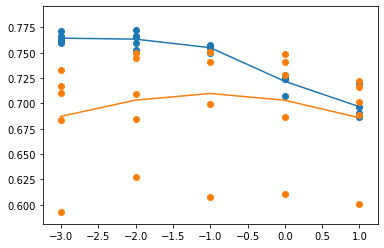

In [1278]:
x = np.log(df_val_res.l2_reg)/np.log(10)

plt.scatter(x,df_val_res.AP_train)
plt.scatter(x,df_val_res.AP_val)

df_grouped = df_val_res.groupby('l2_reg', as_index=False)['AP_train','AP_val'].mean()

plt.plot(np.log(df_grouped.l2_reg)/np.log(10),df_grouped.AP_train)
plt.plot(np.log(df_grouped.l2_reg)/np.log(10),df_grouped.AP_val)

In [1281]:
X_train,y_train,X_val, y_val = stratifiedSplit(X_train_val,y_train_val,
                                                   test_size = 0.1,random_state = 31)

model = build_model(lr=0.001,dropout_rate=0.4,l1reg=0.01,l2reg=0.1)
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
                 ModelCheckpoint(filepath='best_logistic_model.h5', monitor='val_loss', save_best_only=True)]
model.fit(X_train, y_train, batch_size=30, epochs=30, validation_data = (X_val,y_val),
              shuffle=True, callbacks=callbacks,verbose=0)
model = load_model('best_logistic_model.h5',custom_objects={'mean_pred': mean_pred})

logistic has AP: 0.644883403720896 accuracy 0.5538775510204081


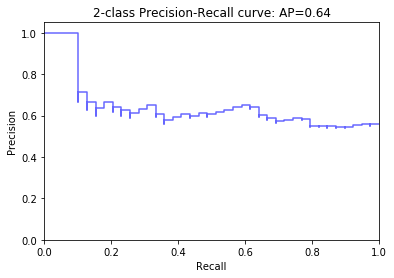

In [1282]:
y_score_logistic = model.predict(X_test)
evaluate_model_pred(y_test,y_score_logistic,model_name='logistic')

## Transfer Learning

In [1010]:
model_pre = load_model('../likes_data/model_pre.h5',custom_objects={'mean_pred': mean_pred})

In [1011]:
model_pre.fit(X_train, y_train, batch_size=batch_size, epochs=10, validation_data = (X_val,y_val), shuffle=True)

Train on 560 samples, validate on 63 samples
Epoch 1/10
560/560 [==============================] - 8s 14ms/step - loss: 0.7890 - acc: 0.5679 - mean_pred: 0.4566 - val_loss: 0.6741 - val_acc: 0.6349 - val_mean_pred: 0.5124
Epoch 2/10
560/560 [==============================] - 2s 3ms/step - loss: 0.4981 - acc: 0.7571 - mean_pred: 0.5213 - val_loss: 0.6342 - val_acc: 0.6349 - val_mean_pred: 0.4300
Epoch 3/10
560/560 [==============================] - 2s 3ms/step - loss: 0.3838 - acc: 0.8268 - mean_pred: 0.5000 - val_loss: 0.6359 - val_acc: 0.6667 - val_mean_pred: 0.5048
Epoch 4/10
560/560 [==============================] - 2s 3ms/step - loss: 0.3262 - acc: 0.8589 - mean_pred: 0.5281 - val_loss: 0.6393 - val_acc: 0.6032 - val_mean_pred: 0.4953
Epoch 5/10
560/560 [==============================] - 2s 3ms/step - loss: 0.2828 - acc: 0.9125 - mean_pred: 0.5273 - val_loss: 0.6451 - val_acc: 0.6190 - val_mean_pred: 0.5134
Epoch 6/10
560/560 [==============================] - 2s 3ms/step - loss: 

1-layer has AP: 0.7465077937603866 accuracy 0.513061224489796


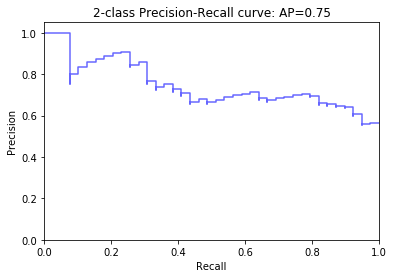

In [1012]:
y_model_pre = model_pre.predict_proba(X_test)
evaluate_model_pred(y_test,y_model_pre,model_name='1-layer')

In [1013]:
model_2_pre = load_model('../likes_data/model_2_pre.h5',custom_objects={'mean_pred': mean_pred})
#model_2_pre.layers[1].trainable=False
model_2_pre.compile(loss='binary_crossentropy',
                  optimizer=Adam(lr=0.001), metrics=['accuracy',mean_pred])
model_2_pre.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_63 (Dropout)         (None, 35000)             0         
_________________________________________________________________
dense_79 (Dense)             (None, 50)                1750050   
_________________________________________________________________
dropout_64 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_80 (Dense)             (None, 1)                 51        
Total params: 1,750,101
Trainable params: 1,750,101
Non-trainable params: 0
_________________________________________________________________


In [1014]:
model_2_pre.fit(X_train, y_train, batch_size=batch_size, epochs=5, validation_data = (X_val,y_val), shuffle=True)

Train on 560 samples, validate on 63 samples
Epoch 1/5
560/560 [==============================] - 20s 36ms/step - loss: 0.7681 - acc: 0.5625 - mean_pred: 0.5058 - val_loss: 0.6984 - val_acc: 0.5556 - val_mean_pred: 0.4800
Epoch 2/5
560/560 [==============================] - 8s 14ms/step - loss: 0.4319 - acc: 0.8357 - mean_pred: 0.5398 - val_loss: 0.7801 - val_acc: 0.5556 - val_mean_pred: 0.5675
Epoch 3/5
560/560 [==============================] - 8s 14ms/step - loss: 0.2453 - acc: 0.9500 - mean_pred: 0.5469 - val_loss: 0.8178 - val_acc: 0.6032 - val_mean_pred: 0.5244
Epoch 4/5
560/560 [==============================] - 8s 14ms/step - loss: 0.1726 - acc: 0.9679 - mean_pred: 0.5566 - val_loss: 0.8790 - val_acc: 0.6032 - val_mean_pred: 0.5545
Epoch 5/5
560/560 [==============================] - 9s 16ms/step - loss: 0.1337 - acc: 0.9875 - mean_pred: 0.5440 - val_loss: 0.9919 - val_acc: 0.5238 - val_mean_pred: 0.5744


1-layer has AP: 0.7330742488466613 accuracy 0.5244897959183673


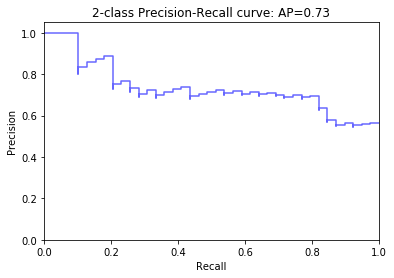

In [1015]:
y_model_2_pre = model_2_pre.predict_proba(X_test)
evaluate_model_pred(y_test,y_model_2_pre,model_name='2-layer')

In [1023]:
model_3_pre = load_model('../likes_data/model_3_pre.h5',custom_objects={'mean_pred': mean_pred})

In [1024]:
#model_3_pre.layers[1].trainable=False
model_3_pre.compile(loss='binary_crossentropy',
                  optimizer=Adam(lr=0.001), metrics=['accuracy',mean_pred])
model_3_pre.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_65 (Dropout)         (None, 35000)             0         
_________________________________________________________________
dense_81 (Dense)             (None, 100)               3500100   
_________________________________________________________________
dropout_66 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_82 (Dense)             (None, 30)                3030      
_________________________________________________________________
dropout_67 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_83 (Dense)             (None, 1)                 31        
Total params: 3,503,161
Trainable params: 3,503,161
Non-trainable params: 0
_________________________________________________________________


In [1036]:
model_3_pre.fit(X_train, y_train, batch_size=batch_size, epochs=1, validation_data = (X_val,y_val), shuffle=True)

Train on 560 samples, validate on 63 samples
Epoch 1/1
560/560 [==============================] - 12s 22ms/step - loss: 0.1154 - acc: 0.9893 - mean_pred: 0.5409 - val_loss: 1.1773 - val_acc: 0.5556 - val_mean_pred: 0.6316


3-layer has AP: 0.7161339708114077 accuracy 0.5277551020408163


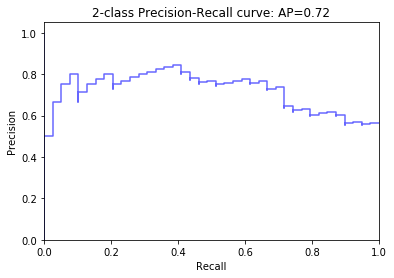

In [1037]:
y_model_3_pre = model_3_pre.predict_proba(X_test)
evaluate_model_pred(y_test,y_model_3_pre,model_name='3-layer')

In [1034]:
#model_3_pre.save('model_3_pre_final.h5')

In [695]:
from xgboost import XGBClassifier

clf = XGBClassifier(max_depth=25, silent=False, n_estimators=40,objective='binary:logistic',reg_alpha=0.01)

In [696]:
clf = clf.fit(X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='logloss',
        verbose=True)

[0]	validation_0-logloss:0.688817
[1]	validation_0-logloss:0.682806
[2]	validation_0-logloss:0.681887
[3]	validation_0-logloss:0.681533
[4]	validation_0-logloss:0.667509
[5]	validation_0-logloss:0.654776
[6]	validation_0-logloss:0.653414
[7]	validation_0-logloss:0.655349
[8]	validation_0-logloss:0.65559
[9]	validation_0-logloss:0.64422
[10]	validation_0-logloss:0.646742
[11]	validation_0-logloss:0.644395
[12]	validation_0-logloss:0.645182
[13]	validation_0-logloss:0.642983
[14]	validation_0-logloss:0.632492
[15]	validation_0-logloss:0.630147
[16]	validation_0-logloss:0.628002
[17]	validation_0-logloss:0.623064
[18]	validation_0-logloss:0.621402
[19]	validation_0-logloss:0.622527
[20]	validation_0-logloss:0.619866
[21]	validation_0-logloss:0.624203
[22]	validation_0-logloss:0.620024
[23]	validation_0-logloss:0.623908
[24]	validation_0-logloss:0.625034
[25]	validation_0-logloss:0.621916
[26]	validation_0-logloss:0.616474
[27]	validation_0-logloss:0.613959
[28]	validation_0-logloss:0.6161

In [697]:
y_pred_xg = clf.predict_proba(X_test)[:,1]

xgboost has AP: 0.6788616945102636 accuracy 0.6857142857142857


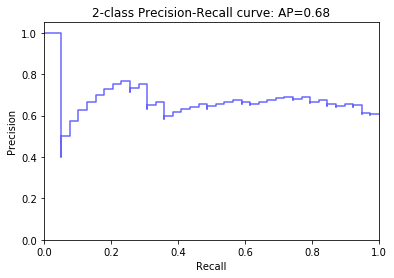

In [698]:
evaluate_model_pred(y_test,y_pred_xg,model_name='xgboost')

In [743]:
len(X_test[0])

35000

In [1038]:
model_4_pre = load_model('../likes_data/model_4_pre.h5',custom_objects={'mean_pred': mean_pred})

In [1039]:
model_4_pre.layers[1].trainable=False
model_4_pre.compile(loss='binary_crossentropy',
                  optimizer=Adam(lr=0.001), metrics=['accuracy',mean_pred])
model_4_pre.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_68 (Dropout)         (None, 35000)             0         
_________________________________________________________________
dense_84 (Dense)             (None, 70)                2450070   
_________________________________________________________________
dropout_69 (Dropout)         (None, 70)                0         
_________________________________________________________________
dense_85 (Dense)             (None, 100)               7100      
_________________________________________________________________
dropout_70 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_86 (Dense)             (None, 30)                3030      
_________________________________________________________________
dropout_71 (Dropout)         (None, 30)                0         
__________

In [1049]:
model_4_pre.fit(X_train, y_train, batch_size=batch_size, epochs=10, validation_data = (X_val,y_val), shuffle=True)

Train on 560 samples, validate on 63 samples
Epoch 1/10
560/560 [==============================] - 2s 4ms/step - loss: 0.9789 - acc: 0.5929 - mean_pred: 0.5519 - val_loss: 0.9836 - val_acc: 0.5556 - val_mean_pred: 0.5438
Epoch 2/10
560/560 [==============================] - 2s 4ms/step - loss: 0.9839 - acc: 0.6107 - mean_pred: 0.5519 - val_loss: 0.9826 - val_acc: 0.5556 - val_mean_pred: 0.5391
Epoch 3/10
560/560 [==============================] - 3s 4ms/step - loss: 0.9845 - acc: 0.5857 - mean_pred: 0.5481 - val_loss: 0.9840 - val_acc: 0.5873 - val_mean_pred: 0.5584
Epoch 4/10
560/560 [==============================] - 2s 4ms/step - loss: 0.9807 - acc: 0.5732 - mean_pred: 0.5541 - val_loss: 0.9846 - val_acc: 0.5397 - val_mean_pred: 0.5499
Epoch 5/10
560/560 [==============================] - 3s 5ms/step - loss: 0.9844 - acc: 0.5839 - mean_pred: 0.5476 - val_loss: 0.9885 - val_acc: 0.5238 - val_mean_pred: 0.5349
Epoch 6/10
560/560 [==============================] - 3s 5ms/step - loss: 0

In [1051]:
model_4_pre.layers[1].trainable=True
model_4_pre.compile(loss='binary_crossentropy',
                  optimizer=Adam(lr=0.001), metrics=['accuracy',mean_pred])
model_4_pre.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_68 (Dropout)         (None, 35000)             0         
_________________________________________________________________
dense_84 (Dense)             (None, 70)                2450070   
_________________________________________________________________
dropout_69 (Dropout)         (None, 70)                0         
_________________________________________________________________
dense_85 (Dense)             (None, 100)               7100      
_________________________________________________________________
dropout_70 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_86 (Dense)             (None, 30)                3030      
_________________________________________________________________
dropout_71 (Dropout)         (None, 30)                0         
__________

In [1054]:
model_4_pre.fit(X_train, y_train, batch_size=batch_size, epochs=1, validation_data = (X_val,y_val), shuffle=True)

Train on 560 samples, validate on 63 samples
Epoch 1/1
560/560 [==============================] - 11s 19ms/step - loss: 0.6567 - acc: 0.8089 - mean_pred: 0.5645 - val_loss: 1.0340 - val_acc: 0.5556 - val_mean_pred: 0.5918


4-layer has AP: 0.6547821933948773 accuracy 0.5244897959183673


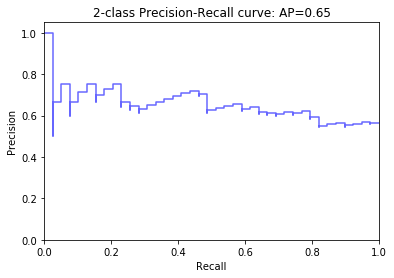

In [1055]:
y_model_4_pre = model_4_pre.predict_proba(X_test)
evaluate_model_pred(y_test,y_model_4_pre,model_name='4-layer')

In [730]:
len(nltk_score)

693

nltk has AP: 0.6517951201120126 accuracy 0.5


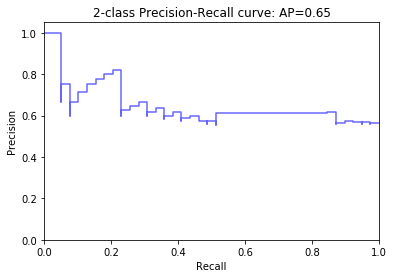

In [877]:
def nltk_sentiment(sentence):
    
    score = nltk_sentiment.polarity_scores(sentence)
    return score

test_sample_mock = random.choices(tweets, k=70)

X_text_test_mock = [' '.join(tweet[2][0]) for tweet in test_sample_mock]

y_text_test_mock = [tweet[1] for tweet in test_sample_mock]

nltk_sentiment = SentimentIntensityAnalyzer()

nltk_score=np.array([(nltk_sentiment.polarity_scores(text)['compound']+1)/2 for text in X_text_test_mock])

evaluate_model_pred(y_text_test_mock,nltk_score,model_name='nltk')

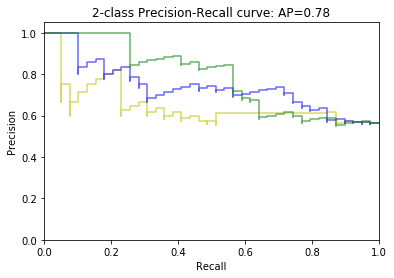

In [1035]:
precision_recall(y_text_test_mock,nltk_score,color='y')
precision_recall(y_test,y_score_logistic,color='b')
#precision_recall(y_test,y_model_pre,color='r')
#precision_recall(y_test,y_model_2,color='r')
precision_recall(y_test,y_model_3_pre,color='g')
plt.show()

In [1042]:
np.save('test_results_6',np.array([y_test,nltk_score,y_score_logistic,y_model_2_pre.reshape(-1),y_model_3_pre.reshape(-1)]))

## Model wrapper

In [1068]:
import re

def text_cleaning(string):
    string += "Edited by"
    string = string[:string.index("Edited by")].replace("\xa0","").replace("\n","").replace("\t","").replace("\r","")
    string = re.sub('\s+', ' ', string).strip()
    return string.replace(" .","").lstrip(".").lstrip(" ").rstrip().replace("...",".").replace("..",".")

def replace_urls(string):
    try:
        url_index = string.index("http")
        string_after = string[url_index:]+" "
        next_space_index = string_after.index(" ")
        string_after = replace_urls(string_after[next_space_index:])
        return (string[:url_index]+' URL '+ string_after).rstrip()
    except: return string

def preprocessing(sentence):
    tweet = text_cleaning(replace_urls(sentence).replace(',',' ')).lower()
    tweet = re.sub(r'((www\.[\S]+)|(https?://[\S]+))', ' URL ', tweet)
    # Replace @handle with the word USER_MENTION
    # Replace 2+ dots with space
    tweet = re.sub(r'\.{2,}', ' ', tweet)
    tweet = re.sub('\.',' ',tweet)
    # Strip space, " and ' from tweet
    tweet = tweet.strip(' "\'')
    # Replace multiple spaces with a single space
    tweet = re.sub(r'\s+', ' ', tweet)
            
    return tweet.lstrip().rstrip()

def get_feature_vector(tweet):
    uni_feature_vector = []
    bi_feature_vector = []
    words = tweet.split()
    for i in range(len(words) - 1):
        word = words[i]
        next_word = words[i + 1]
        if unigrams.get(word):
            uni_feature_vector.append(word)        
        if bigrams.get((word, next_word)):
            bi_feature_vector.append((word, next_word))
    if len(words) >= 1:
        if unigrams.get(words[-1]):
            uni_feature_vector.append(words[-1])
    return uni_feature_vector, bi_feature_vector

def sentence_to_vec(sentence):
    #unigrams and bigrams are externally defined dictionaries
    s_words,s_bigrams = get_feature_vector(sentence)
    features = np.zeros(VOCAB_SIZE)
    for word in s_words:
        idx = unigrams.get(word)
        if idx: features[idx] += 1
    for bigr in s_bigrams:
        idx = bigrams.get(word)
        if idx: features[UNIGRAM_SIZE + idx] += 1
    return features

def model_prediction(model,sentence):
    #from sentence to result
    vec = sentence_to_vec(sentence)
    return model.predict(vec.reshape(1,-1))[0][0]

sentence = 'astigmatism'
print(model_prediction(model_3_pre,sentence),nltk_sentiment.polarity_scores(sentence))

0.62298334 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}


In [ ]:
preprocessing(sentence)

In [1067]:
sentence = "Pentax XW pairs work fine for me in every BT I've owned including the big BT100-45 from Obie and the semi-APO and APO (both 45 and 90) APM binos. Please note that at less than f/6, the XW 20 and 14's show some field curvature to my eyes. The outer edge and center can't be focused together. The XW10's are superb."
sentence = preprocessing(sentence)
print(sentence)
print(model_prediction(model_3_pre,sentence),nltk_sentiment.polarity_scores(sentence))

sentence = "Thanks for the post/review and congrats on the new instrument, Rick. This beast sounds really incredible. I’m amazed at the power you guys are using it at. Between the higher powers and the dual eyed perspective these instruments are really not giving much of anything up compared to more traditional planetary instruments. On the other hand, the light grasp and low powered sweeping are light years beyond what most other instruments will provide."
sentence = preprocessing(sentence)
print(sentence)
print(model_prediction(model_3_pre,sentence),nltk_sentiment.polarity_scores(sentence))


pentax xw pairs work fine for me in every bt i've owned including the big bt100-45 from obie and the semi-apo and apo (both 45 and 90) apm binos please note that at less than f/6 the xw 20 and 14's show some field curvature to my eyes the outer edge and center can't be focused together the xw10's are superb
0.950166 {'neg': 0.032, 'neu': 0.846, 'pos': 0.122, 'compound': 0.7198}
thanks for the post/review and congrats on the new instrument rick this beast sounds really incredible i’m amazed at the power you guys are using it at between the higher powers and the dual eyed perspective these instruments are really not giving much of anything up compared to more traditional planetary instruments on the other hand the light grasp and low powered sweeping are light years beyond what most other instruments will provide
0.36299768 {'neg': 0.052, 'neu': 0.794, 'pos': 0.154, 'compound': 0.8608}


In [945]:
def get_feature_vector(tweet):
    uni_feature_vector = []
    bi_feature_vector = []
    words = tweet.split()
    for i in range(len(words) - 1):
        word = words[i]
        next_word = words[i + 1]
        if unigrams.get(word):
            uni_feature_vector.append(word)
        if USE_BIGRAMS:
            if bigrams.get((word, next_word)):
                bi_feature_vector.append((word, next_word))
    if len(words) >= 1:
        if unigrams.get(words[-1]):
            uni_feature_vector.append(words[-1])
    return uni_feature_vector, bi_feature_vector

## Export production models

In [1188]:
model_likes = load_model('../likes_data/model_pre_59.h5',custom_objects={'mean_pred': mean_pred})

model_likes.compile(loss='binary_crossentropy',optimizer=Adam(lr=0.001))
model_likes.save('../likes_data/model_likes_prod.h5')
del model_likes

In [1193]:
#model_senti = load_model('model_3_pre_final.h5',custom_objects={'mean_pred': mean_pred})
#model_senti.compile(loss='binary_crossentropy',optimizer=Adam(lr=0.001))
#model_senti.save('model_senti_3.h5')
#del model_senti

pkl_filename = "pickle_logistic_sentiment.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(logistic, file)
    
# Load from file
with open(pkl_filename, 'rb') as file:
    pickle_model = pickle.load(file)
    
y_score_logistic = pickle_model.predict_proba([X_test[0]])[:,1][0]

In [1194]:
y_score_logistic

0.4037106694206202

## Testing

In [223]:
y_test = test_set_y
y_score = logistic_pre.predict(test_set_X).reshape(-1)
y_score_2 = model_2_pre.predict(test_set_X).reshape(-1)
y_score_3 = model_3_pre.predict(test_set_X).reshape(-1)

In [224]:
print("1 layer model has AP", average_precision_score(y_test, y_score), "accuracy", accuracy(y_test,y_score))
print("2 layer model has AP", average_precision_score(y_test, y_score_2), "accuracy", accuracy(y_test,y_score_2))
print("3 layer model has AP", average_precision_score(y_test, y_score_3), "accuracy", accuracy(y_test,y_score_3))

1 layer model has AP 0.6463870036992461 accuracy 0.6571428571428571
2 layer model has AP 0.7124336573235572 accuracy 0.6285714285714286
3 layer model has AP 0.7400632947467144 accuracy 0.6428571428571429


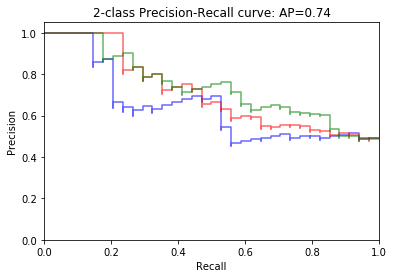

In [225]:
precision_recall(y_test,y_score)
precision_recall(y_test,y_score_2,color='r')
precision_recall(y_test,y_score_3,color='g')
plt.show()

Logistic regression has AP: 0.7559089372154512 accuracy 0.6285714285714286


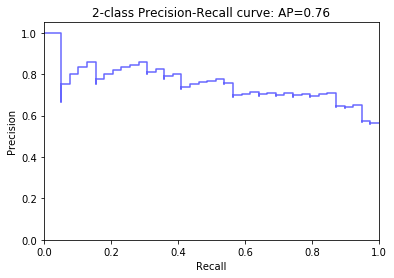

In [359]:
y_score_logistic = logistic.predict_proba(X_test)[:,1]
print("Logistic regression has AP:", average_precision_score(y_test, y_score_logistic), 
      "accuracy", accuracy(y_test,y_score_logistic))

precision_recall(y_test,y_score_logistic)

In [367]:
y_score_model = model.predict(X_test)

